In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import models, optimizers, regularizers
import cv2
import os
import numpy as np

### Cargamos los datos Forma 1

In [2]:
Data_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
CATEGORIES=["NORMAL","PNEUMONIA"]

Se creará una función que me **cree un arreglo a partir de las imagenes** deseadas

In [3]:

img_size= 200
def get_data(Data_dir):
    data=[]
    for category in CATEGORIES: 
            path = os.path.join(Data_dir,category)
            class_num=CATEGORIES.index(category)
            for img in os.listdir(path):
                img_array= cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_array=cv2.resize(img_array,(img_size,img_size))
                data.append([resized_array,class_num])
    return np.array(data)
                


### Cargar datos forma 2
# ESTA ES LA FORMA RECOMENDADA PARA LEER LA INFORMACIÓN DE UN DIRECTORIO

In [4]:
#generando las imagenes del entrenamiento
train_datagen=ImageDataGenerator(rescale= 1./255,
                  rotation_range=40,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2,
                   zoom_range=0.2,
                   horizontal_flip=True
                  )

In [5]:
#generando las imagenes de test
test_datagen= ImageDataGenerator(rescale=1./255)

In [6]:
train_generator=train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
                                 target_size=(200,200),
                                 batch_size=32,
                                 class_mode="binary")

validation_generator=test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val",
                                 target_size=(200,200),
                                 batch_size=32,
                                 class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Podemos observar que detecta 5216 imagenes de 2 clases y 16 imágenes de validación, tal vez son muy pocas, pero se continuará

Lo que se está haciendo es una alternativa para la lectura de los datos del dataset, a partir de una función nativa de keras.preprocessing.image 

## Modelo

In [7]:
model=models.Sequential()

model.add(Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

### Entrenamos el modelo

In [8]:
checkpoint= ModelCheckpoint("modelo_deteccion_neumonia",verbose=1,save_best_only=True)

In [9]:
model.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=["accuracy"])

In [10]:
hist= model.fit(train_generator,
                steps_per_epoch=5216//32,
                epochs=20,
                validation_data=validation_generator,
                validation_steps=1,
                callbacks=[checkpoint]
               )

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.7774
Epoch 1: val_loss improved from inf to 0.58929, saving model to modelo_deteccion_neumonia
163/163 [==============================] - 147s 862ms/step - loss: 0.4744 - accuracy: 0.7774 - val_loss: 0.5893 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8347
Epoch 2: val_loss improved from 0.58929 to 0.42610, saving model to modelo_deteccion_neumonia
163/163 [==============================] - 109s 669ms/step - loss: 0.3529 - accuracy: 0.8347 - val_loss: 0.4261 - val_accuracy: 0.7500
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8643
Epoch 3: val_loss did not improve from 0.42610
163/163 [==============================] - 107s 655ms/step - loss: 0.3086 - accuracy: 0.8643 - val_loss: 0.4831 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - ETA: 0s - loss: 0.2790

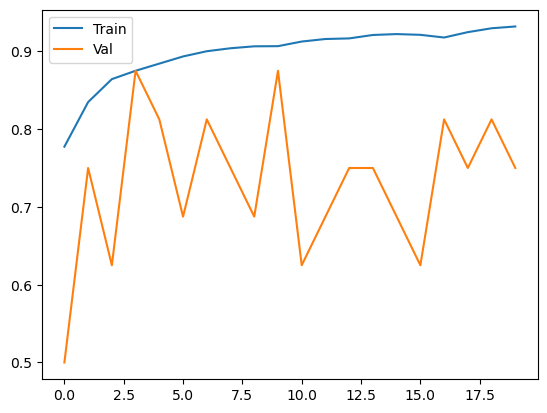

In [11]:
plt.plot(hist.history["accuracy"],label="Train")
plt.plot(hist.history["val_accuracy"],label="Val")
plt.legend()
plt.show()

In [12]:
test_generator=test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test",
                                 target_size=(200,200),
                                 batch_size=32,
                                 class_mode="binary")

Found 624 images belonging to 2 classes.


In [13]:
model2=model

In [14]:
model2.load_weights("modelo_deteccion_neumonia")

In [15]:
print("El accuracy del modelo es ",model2.evaluate(test_generator)[1])

20/20 [==============================] - 9s 458ms/step - loss: 0.2760 - accuracy: 0.9231
El accuracy del modelo es  0.9230769276618958
